## Building a neural network using numpy

In the article, you understood how a neural network is composed of a network of neurons that area able to understand the input data by optimizing the weights and biases.<br>
In this notebook, we will build a simple, single neuron neural network from scratch without using any of the pre built libraries. The logic can be expanded to multiple layers with more variables to keep track of.

## The problem: Cat Detection 
The task is to classify if a given image contains a cat or not. While the image might seem to be very complex to interpret compared to our example loan problem, the concepts remain the same. Each pixel of the image would be considered as an input feature which would we weighed differently by the neuron.

create conents of the notebook with a link to go to that section of the notebook


### 1. Import required libraries
Let us start the exercise by importing the required libraries

In [2]:
# building neural network from scratch
import numpy as np  # to perform matrix operations
import matplotlib.pyplot as plt # to visualize images
import h5py # to interact with a dataset that is stored on an H5 file
import copy # to copy the parameters of the model. This feature is used when we try to update the weights of neurons
from sklearn.metrics import confusion_matrix # to look at the performance of the model compared to the actual labels
import seaborn as sns # to visualize images

### 2. Load and visulize the data

We will load the train and test datasets which are stored in h5 format and look at a few images

In [3]:
# load train and test data from h5 files
train = h5py.File('data/train_catvnoncat.h5', "r")
test = h5py.File('data/test_catvnoncat.h5', "r")

#split train into X and Y
train_x = np.array(train["train_set_x"][:]) # your train set features
train_y = np.array(train["train_set_y"][:]) # your train set labels

#split test into X and Y
test_x = np.array(test["test_set_x"][:]) # your test set features
test_y = np.array(test["test_set_y"][:]) # your test set labels

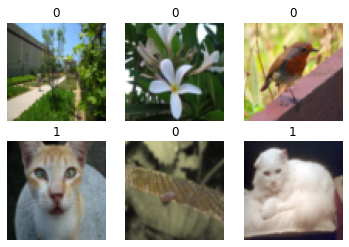

In [4]:
# visualizing 5 images from train dataset more easily visualizable and labels of the images

for i in range(6):
    # subplot: 2 row, 3 columns, i+1 is the index of subplot
    plt.subplot(2,3,i+1)

    plt.imshow(train_x[i+8], cmap='gray')
    plt.title(train_y[i+8])
    plt.axis('off')



We have a mix of cats and non-cats images in different angles and positions.

Before we build our neural network, let's process the data to feed to a neural network.

### 3.Processing data
As each pixel of the image is an input feature, we need to flatten the grid of pixels into a column/vector of pixels. Further, since these images are colored images, we would have 3 channels, each for Red, Green and Blue. So, we need to flatten the image into a column/vector of pixels for each channel. 

- Let us first start by looking at the dimensions of the data we have.

In [5]:
# number of images
print("Number of training examples: ", train_x.shape[0])
print("Number of test examples: ", test_x.shape[0])

# size of image
print("Size of image: ", train_x.shape[1:3])

# number of channels color
print("Number of channels: ", train_x.shape[3])

Number of training examples:  209
Number of test examples:  50
Size of image:  (64, 64)
Number of channels:  3


- We see that there are 209 images to train and 50 images to test
- Each image is of size 64X64 which means we have 4096 pixels
- There are 3 channels which are for the Red, Green, and Blue channels. 

Picture Fact:
Each pixel has a value ranging from 0 to 255 where 0 is no intensity and 255 is full intensity. The intensity of red, green, and blue are combined to create the color of the pixel.

So our total number of input features per image would be 64X64X3 = 12288 which we will now stack into a matric where each column would be the pixels of one image using numpy library.

In [6]:
# flatten train_x and train_y
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T

# shape of train_x_flatten and train_y_flatten
print("train_x_flatten shape: " + str(train_x_flatten.shape))
print("train_y_flatten shape: " + str(test_x_flatten.shape))

# standardize the dataset
X_train = train_x_flatten / 255.
X_test = test_x_flatten / 255.



train_x_flatten shape: (12288, 209)
train_y_flatten shape: (12288, 50)


We also standardized the features by dividing with 255 as each pixel in an image would range from 0 to 255, this would limit the values between 0 and 1

Now that our data is processed, let us start with peicing together the components of neural network mathematically.

### 4.Forward Propagation

In the forward propagation, each neuron would weigh each of the inputs and add a bias term to it. This would be processed through an activation function which would then be passed on to the next layer which would repeat the same process again until the last neuron predicts the output.

Let us mathematically visualize this for our neural network. 

- First we weigh our inputs and add a bias term to it
$$Z=x_{1}w_{1} + x_{2}w_{2} + x_{3}w_{3} +...... x_{12288}w_{12288} + bias \tag{1} $$
where, <br>
 $x_{i}$ is the ith input feature <br>
 $w_{i}$ is the weight assigned to the ith input feauture

- Next we pass this value through an activation function. In this exercise, we will use the sigmoid function as the activation function which also predicts the output $\hat{y}$
$$\hat{y} = a = sigmoid(Z)\tag{2}$$ 

- If we had several layers with multiple neurons in the previous layer, we would repeat the same process and the equations would look like this
$$Z_{<2>(1)}=a_{<1>(1)}w_{<2>(1),1} + a_{<1>(2)}w_{<2>(1),2} + a_{<1>(3)}w_{<2>(1),3} +...... a_{<1>(n)}w_{<2>(1),n} + bias_{<2>(1)} \tag{3} $$
where, <br>
 $Z_{<2>(1)}$ is the calculated value for the 1st neuron in the 2nd layer <br>
 $a_{<1>(i)}$ is the output of the ith neuron in the 1st layer which would be the output of the actication function <br>
 $w_{<2>(1),i}$ is the weight assigned to ith activation function output of the 1st layer by the neuron first neuron in the 2nd layer <br>

You can see how it starts to get confusing by adding a second layer. However, there are ways to simplify this process using matrices which we will see later and stick to single layer, single neuron for now.



 ### Inspiration for matrix implementation

We have seen the methods to build a neural network from scratch and with a single neuron, there are 12289 parameters (ChatGPT has billions of parameters) which need to be stored, computed, and updated everytime. This process if we do sequentially would take a lot of time and memory.

This is where matrices come into play where we can process multiple inputs as matrices like we already did in the processing step.
Further, each layer has multiple neurons, the weights of these can also be stored in a matrix where each column would be the weights of each neuron in that layer.

Then our forward propagation would be a dot product between the input matrix and the weight matrix and then adding the bias term to it.

X would be a matrix of size mxn where n would be the number of features and m would be the number of samples
W would be a row matrix of weights that would contain the weights associated with each of the features of size mx1
b would be a scalar value for the bias that gets added to all the calculations. Due to property called [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html), we need not create duplicates of bias for each training example as python takes case of it. 

Notice that the number of features in X matches the number of weights in W. This is essential for matrix multiplication and often several times the network would throw an error if the dimensions do not match.

Then our computation for Z would be a dot product between X and W (making sure the dimensions match)

$$Z = W^{T}.X + b \tag{4}$$

Here Z is a 1xn matrix as we have only one neuron in this layer. 
Remember that the dot product results in 1xn matrix and the bias term is added to each of the n elements through broadcasting.


If we had 3 neurons in this layer, then each of them would have their own weights and biases resulting in 3 values of Z
In this scenario, <br>
The input X would be mxn <br>
The weight matrix W would be mx3 <br>
The bias b would be a matrix with a bias element for each neuron being 3x1 (again broadcasting handles adding the bias term to each of the training examples)

PS: Matrices are denoted by capital letters and vectors are denoted by small letters and this is a convention followed in most of the literature.


##### 4.a Activation Functions
There are several activation functions available for use in neural networks. The most common ones are sigmoid, tanh, ReLU, Leaky ReLU, etc. Each of these functions have their own advantages and disadvantages. However, since this single neuron needs to predict a binary output, we are using the sigmoid function as the activation function.

The sigmoid activation function is of the following form
$$sigmoid(x) = \frac{1}{1+e^{-x}} \tag{5}$$
And it looks like this when plotted 


<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png" alt="sigmoid" width="400" height="300" />
</p>


The sigmoid function limits any value between 0-1 which would then act as a probability value (greater than 0.5 meaning true) which makes the ideal choice as the output layer in binary classifications.

If you want to learn more about activation functions, you can read this [article](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

We have now seen how the forward propagation works in a neural network. Let us implement these functions before we proceed to backward propagation.


### Implementing parts of Forward Propagation
1. Sigmoid Function
2. Initalization


In [7]:
# Sigmoid function

def sigmoid(x):
    """"
    Calculate sigmoid of x

    Arguments:
    x -- A numpy array of any size

    Formula:
    s(x) = 1 / (1 + e^(-x))

    """
    return 1 / (1 + np.exp(-x))

In [8]:
# Initialization

def initialization(dims):
    """
    Arguments:
    dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    w -- weight matrix of shape (dims, 1)
    b -- bias vector of shape (1, 1)

    """
        
    w = np.zeros((dims, 1))
    b = 0.0
    
  
    return w, b


### 5. Loss Function

Before we start backward propagation, we need to define a loss function which would help us measure the error in prediction. 

How do we measure the error in prediction? <br>
There are several ways to measure the error in prediction, it could be the difference in absolute numbers, percent difference, etc.
In this exercise, as we want to measure how our close the probability is to the true value (0 being not car and 1 being cat), we will use the cross entropy loss function which is of the following form

$$J = -(y\log(\hat{y})+(1-y)\log(1-\hat{y})) \tag{6}$$

Where y is the true value 1 being $\hat{y}$ "cat" and 0 being "not a cat" <br>

When the true value is 1, the second term in the equation becomes 0 and the first term becomes the loss function. Similarly, when the true value is 0, the first term becomes 0 and the second term becomes the loss function and calculate the deviation from the true value.



### 6. Backward Propagation

Now that we have calculated our loss function to compute the error in prediction, we can start the back propagation step to optimize our weights and biases to reduce the error in prediction.

If we look at the loss function, we can rewrite it as follows
$$J = -(y\log(a)+(1-y)\log(1-a)) \tag{7}$$

and we know that the activation function is a function of weighted sum of inputs and bias term which if we substitute in the above equation, we get

$$J = -(y\log(sigmoid(z))+(1-y)\log(1-sigmoid(z))) \tag{8}$$

refining it further, we get

$$J = -(y\log(\frac{1}{1+e^{-(x_{1}w_{1} + x_{2}w_{2} + x_{3}w_{3} +...... x_{12288}w_{12288} + bias)}})+(1-y)\log(1-\frac{1}{1+e^{-(x_{1}w_{1} + x_{2}w_{2} + x_{3}w_{3} +...... x_{12288}w_{12288} + bias)}})) \tag{9}$$

We need to optimize the weights and biases to reduce the error. To do this, we need to look at how much the loss function changes when we slightly change the weight of one of the inputs. This is where partial derivatives come into play.
In principle, the change in loss function value when we change the weight of one of the inputs is the partial derivative of the loss function with respect to the weight of that input.

This means that change the weight of the input slightly will change the loss function by the value of the partial derivative and we can move closer towards minimizing our loss.

Calculating the partial derivatives is not that complex but we will skip the math behind it for now. However, if you are interested, you can ask ChatGPT to explain or read this [article](https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e)

Now, if we had several layers, the partial derivatives would be calculated for each of the neurons in each of the layers in a similar way using the chain rule. I would recommend this video by Andrej Karpathy who dives into how we compute the partial derivates for all the neurons in a complex neural network efficiently [video](https://www.youtube.com/watch?v=Ilg3gGewQ5U)

To give a brief idea of how the chain rule works, let us apply it to our single neuron neural network.
The partial derivative of the loss function with respect to the weight of the ith input would be

$$\frac{\partial J}{\partial W} = \frac{\partial J}{\partial A}\frac{\partial A}{\partial Z}\frac{\partial Z}{\partial W} \tag{10}$$

where, <br>
$\frac{\partial J}{\partial A}$ is the partial derivative of the loss function with respect to the activation function output <br>
$\frac{\partial a}{\partial Z}$ is the partial derivative of the activation function with respect to the weighted sum of inputs and bias <br>
$\frac{\partial z}{\partial W}$ is the partial derivative of the weighted sum of inputs and bias with respect to the weights <br>

We will skip the calculations which would eventually lead us to the following equation in matrix form

$$ \frac{\partial J}{\partial W} = \frac{1}{m}X(A-Y)^T\tag{11}$$

Similarly for bias, we get
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{12}$$

We have almost completed the backward propagation step. We have calculated the partial derivatives of the loss function with respect to the weights and biases. Now, we need to update the weights and biases to reduce the loss function value but only a small amount which we will call the learning rate  $\alpha$

Let us now update the weights and biases using the following equations with a learning rate $\alpha$

$$W = W - \alpha\frac{\partial J}{\partial W} \tag{13}$$
$$b = b - \alpha\frac{\partial J}{\partial b} \tag{14}$$



In [9]:
# propagate and compute loss function, partial derivatives
# for weights and biases

def propagate(X,y,w,b):
    """
    Implement the cost function and its gradient for the propagation explained above
    Arguments:
    X -- data set of shape (number of features, number of examples)
    y -- labels of shape (1, number of examples)
    w -- weights of shape (number of features, 1)
    b -- bias, a scalar

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    # compute activation
    A = sigmoid(np.dot(w.T,X)+b)
    # compute cost
    epsilon = 1e-5
    cost = -np.sum(y*np.log(A+epsilon)+(1-y)*np.log(1-A+epsilon))/m
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X,(A-y).T)/m
    db = np.sum(A-y)/m

  
    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw,
            "db": db}

    return grads,cost


In [10]:
# optimize the neural network 

def optimize(w,b,X,y,num_iterations=100,learning_rate=0.01,print_cost=False):
    """
    Optimizing the neural network by performing multiple iterations of forward and backward propagation updating the parameters w and b

    Arguments:
    w -- weights, a numpy array of size (num_px*num_px*3,1)
    b -- bias, a scalar
    X -- data of size (num_px*num_px*3,number of examples)
    y -- true "label" vector (containing 0 if non-cat, 1 if cat), of size (1,number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """
    w= copy.deepcopy(w)
    b= copy.deepcopy(b)
    
    costs=[]
    for i in range(num_iterations):
        grads,cost=propagate(X,y,w,b)
        dw=grads['dw']
        db=grads['db']

        # updating the parameters by a slight change using learning rate
        w=w-learning_rate*dw
        b=b-learning_rate*db

       
        if i%100==0:
            costs.append(cost)
        if print_cost and i%100==0:
            print('Cost after iteration %i: %f'%(i,cost))
    
    # print(costs)
    params={'w':w,'b':b}
    grads={'dw':dw,'db':db}
    return params,grads,costs

In [11]:
# prediction on new/test data

def predict(w,b,X ):
    '''
    Predict the output of the neural network given the parameters w and b and input X
    
    Arguments:
    w -- weights, a numpy array of size (num_features,1)
    b -- bias, a scalar
    X -- data of size (num_features, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0

    assert(Y_prediction.shape == (1, m))

    return Y_prediction
    

### Building the model

Now that we have understood the mathematical aspects of forward and backward propagation of a neural network and the required functions to build a network.

Lets build a neural network that trains on the images for 5000 iterations



In [12]:
def model(train_x, train_y, test_x, test_y, num_iterations = 1000, learning_rate = 0.005, print_cost=False):
    """
    Builds a classification model  incorporating all the components
    
    Arguments:
    train_x -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    train_y -- training labels represented by a numpy array (vector) of shape (1, m_train)
    test_x -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    test_y -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    w, b = initialization(train_x.shape[0])
    
    # forward and backward propagation
    parameters, grads, costs = optimize(w, b, train_x, train_y, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    y_prediction_test = predict(w, b, test_x)
    y_prediction_train = predict(w, b, train_x)
    
    # Print train/test errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - train_y)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - test_y)) * 100))
    


    d = {"costs": costs,
         "y_prediction_test": y_prediction_test,
         "y_prediction_train": y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}
    
    return d


In [13]:
# training the model
cat_detection_model = model(X_train,train_y,X_test,test_y,learning_rate = 0.001, num_iterations= 5000,print_cost=True)

Cost after iteration 0: 0.693127


Cost after iteration 100: 0.591271
Cost after iteration 200: 0.555778
Cost after iteration 300: 0.528959
Cost after iteration 400: 0.506864
Cost after iteration 500: 0.487863
Cost after iteration 600: 0.471091
Cost after iteration 700: 0.456029
Cost after iteration 800: 0.442334
Cost after iteration 900: 0.429766
Cost after iteration 1000: 0.418148
Cost after iteration 1100: 0.407346
Cost after iteration 1200: 0.397254
Cost after iteration 1300: 0.387786
Cost after iteration 1400: 0.378873
Cost after iteration 1500: 0.370456
Cost after iteration 1600: 0.362485
Cost after iteration 1700: 0.354919
Cost after iteration 1800: 0.347722
Cost after iteration 1900: 0.340862
Cost after iteration 2000: 0.334312
Cost after iteration 2100: 0.328047
Cost after iteration 2200: 0.322046
Cost after iteration 2300: 0.316290
Cost after iteration 2400: 0.310761
Cost after iteration 2500: 0.305446
Cost after iteration 2600: 0.300328
Cost after iteration 2700: 0.295397
Cost after iteration 2800: 0.290641
C

In [14]:
def cost_plot(cat_detection_model):
    #plotting cost function
    plt.plot(cat_detection_model['costs'])
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Loss Function')
    plt.show()

In [15]:
def confusion(test_y, cat_detection_model):

    # Confusion matrix for cat detection model
    conf_matrix = confusion_matrix(test_y, cat_detection_model['y_prediction_test'].flatten())


    # Plotting the confusion matrix with labels of true and predicted using seaborn blue tone  replace 0 and 1 with your labels
    
    p =sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['non-cat','cat'], yticklabels=['non-cat','cat'])
    #adding axis labels and title
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for Cat Detection Model')
    p.plot()


## Results

- We have completed building and testing our neural network. While the test accuracy is not 100%, the single neuron neural network is able to perform well.

- You can tweak around the learning rate and number of epochs to get better results or add more diverse data to the training set.

- You can also try initializing the weights and biases to different values and see how it affects the accuracy.

Let us look at how the loss function evolves over time during the training of neural network using the costs computed in every iteration and the confusion matrix


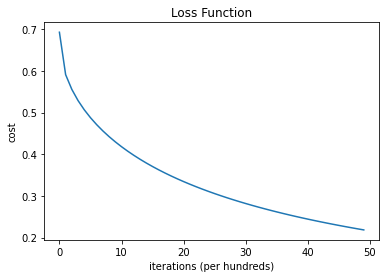

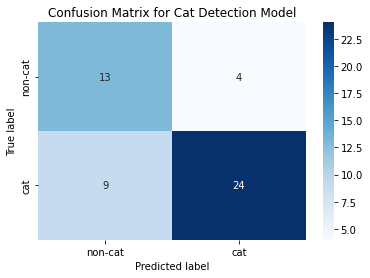

In [18]:
cost_plot(cat_detection_model)
confusion(test_y, cat_detection_model)

- We see that there is a gradual decline in the cost function that is expected through gradient descent
- Looking at the confusion matrix, we see that the model is able to predict the correct class with  decent accuracy.